In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the dataset class
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, set_number, sample_rate=16000, n_mfcc=13, n_mels=128):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        return [idx for idx in range(len(self.data)) if int(self.data.iloc[idx, 1]) == self.set_number]

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        class_label = int(self.data.iloc[idx, 2])
        try:
            waveform, _ = librosa.load(file, sr=self.sample_rate)
            spectrogram = librosa.feature.melspectrogram(y=waveform, sr=self.sample_rate, n_mels=self.n_mels, hop_length=128, n_fft=2048)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrogram = np.expand_dims(spectrogram, axis=0)  # Add channel dimension
            spectrogram = (spectrogram - spectrogram.mean()) / spectrogram.std()  # Normalize
            return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(class_label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            return self.__getitem__((idx + 1) % len(self.filtered_indices))  # Load next sample

# Load the datasets
csv_file = 'dataset.csv'
root_dir = 'Inregistrari'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)

In [4]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):
    print(X.shape, y.shape)
    if batch == 3:
        break

# Print class distribution
class_counts = train_dataset.data.iloc[train_dataset.filtered_indices, 2].value_counts()
print("Class distribution in training set:", class_counts)

torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
Class distribution in training set: class
4    60
0    60
2    59
5    57
3    55
1    45
Name: count, dtype: int64


In [5]:
import torch
import torch.nn as nn
import torchvision.models as models


def get_vgg(version=16, freeze=False, num_classes=10, device='cpu', pretrained=None):
    vgg = models.__dict__[f'vgg{version}'](pretrained=True)
    
    if freeze:
        for param in vgg.parameters():
            param.requires_grad = False
    
    # Modify the first convolutional layer to accept 1 input channel
    vgg.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
    # Modify the fully connected layer to match the number of classes
    vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=num_classes, bias=True)
    
    if pretrained:
        vgg.load_state_dict(torch.load(pretrained))
    
    return vgg.to(device)

model = get_vgg(version=16, freeze=False, num_classes=10, device=device)
print(model)

c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate
criterion = nn.CrossEntropyLoss()

In [12]:

# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    train_losses = []
    train_accuracies = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data =data.repeat(1, 3, 1, 1)
        # data = data.squeeze(1)  # Remove channel dimension
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    scheduler.step()
    return avg_loss, accuracy

In [19]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

all_preds = []
all_targets = []
# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_losses = []
    test_accuracies = []
   
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.repeat(1, 3, 1, 1)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return avg_test_loss, accuracy, all_preds, all_targets


In [21]:
n_epoch = 5
log_interval = 20

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    all_preds = []
    all_targets = []
    for epoch in range(1, n_epoch + 1):
        loss, acc = train(model, device, train_loader, optimizer, epoch, log_interval, scheduler)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(acc)

        loss, acc, preds, targets = test(model, device, test_loader)
        test_epoch_losses.append(loss)
        test_epoch_accuracies.append(acc)
        torch.save(model.state_dict(), 'vgg_command.pt')
        pbar.update(1)


  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/336 (0%)]	Loss: 0.002828

Test set: Average loss: 0.1913, Accuracy: 90/96 (94%)



 20%|██        | 1/5 [01:11<04:47, 71.90s/it]

Train Epoch: 2 [0/336 (0%)]	Loss: 0.005357

Test set: Average loss: 0.5522, Accuracy: 88/96 (92%)



 40%|████      | 2/5 [02:20<03:30, 70.09s/it]

Train Epoch: 3 [0/336 (0%)]	Loss: 0.010186

Test set: Average loss: 0.1111, Accuracy: 92/96 (96%)



 60%|██████    | 3/5 [03:29<02:19, 69.59s/it]

Train Epoch: 4 [0/336 (0%)]	Loss: 0.000010

Test set: Average loss: 0.1322, Accuracy: 93/96 (97%)



 80%|████████  | 4/5 [04:38<01:09, 69.41s/it]

Train Epoch: 5 [0/336 (0%)]	Loss: 0.002087

Test set: Average loss: 0.0606, Accuracy: 92/96 (96%)



100%|██████████| 5/5 [05:49<00:00, 69.99s/it]


ValueError: x and y must have same first dimension, but have shapes (150,) and (5,)

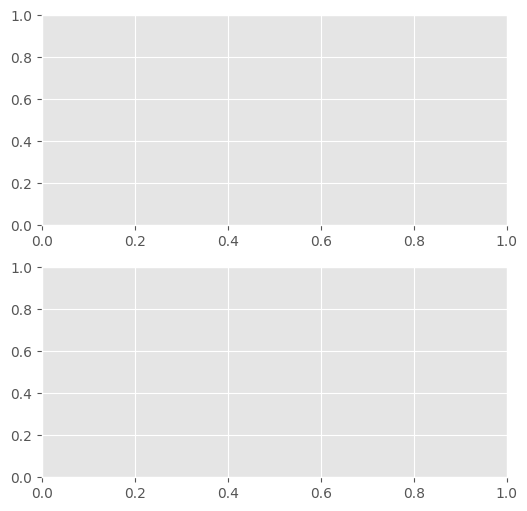

In [36]:
num_epochs = 150
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# # Plot training loss and test loss in the same subplot
# axs[0].plot(epochs[:len(train_losses)], train_losses, label='Training Loss', color='tab:red')
# axs[0].plot(epochs[:len(test_losses)], test_losses, label='Test Loss', color='tab:orange')
# axs[0].set_title('Training & Test Loss')
# axs[0].set_xlabel('Iteration')
# axs[0].set_ylabel('Loss')
# axs[0].legend()

# # Plot training accuracy and test accuracy in the same subplot
# axs[1].plot(epochs[:len(train_accuracies)], train_accuracies, label='Training Accuracy', color='tab:green')
# axs[1].plot(epochs[:len(test_accuracies)], test_accuracies, label='Test Accuracy', color='tab:blue')
# axs[1].set_title('Training & Test Accuracy')
# axs[1].set_xlabel('Iteration')
# axs[1].set_ylabel('Accuracy')
# axs[1].legend()

# # Adjust layout to prevent overlap
# plt.tight_layout()

# plt.show()

# Plot training loss and test loss in the same subplot
plt.plot(epochs[train_epoch_losses], train_epoch_losses, label='Training Loss', color='tab:red')
plt.plot(epochs[test_epoch_losses], test_epoch_losses, label='Test Loss', color='tab:orange')
plt.title('Training & Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy and test accuracy in the same subplot
plt.plot(epochs[train_epoch_accuracies], train_epoch_accuracies, label='Training Accuracy', color='tab:green')
plt.plot(epochs[test_epoch_accuracies], test_epoch_accuracies, label='Test Accuracy', color='tab:blue')
plt.title('Training & Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()





In [ ]:
#load the model vgg_command.pt
model.load_state_dict(torch.load('vgg_command.pt'))

# plot the confusion matrix
from sklearn.metrics import confusion_matrix

all_preds = []
all_targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = data.repeat(1, 3, 1, 1)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())    

              precision    recall  f1-score   support

       start       0.76      0.95      0.84        60
        stop       0.97      0.84      0.90       110
        home       1.00      1.00      1.00        75
     pick_up       0.99      0.97      0.98        95
    approach       0.96      0.99      0.97        70
        free       1.00      1.00      1.00        70

    accuracy                           0.95       480
   macro avg       0.95      0.96      0.95       480
weighted avg       0.95      0.95      0.95       480

[[57  3  0  0  0  0]
 [18 92  0  0  0  0]
 [ 0  0 75  0  0  0]
 [ 0  0  0 92  3  0]
 [ 0  0  0  1 69  0]
 [ 0  0  0  0  0 70]]


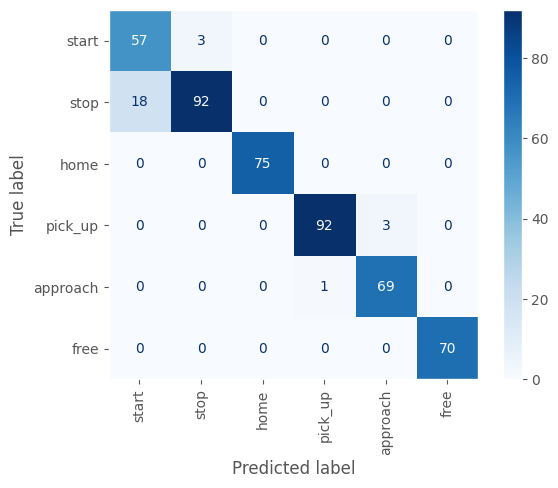

In [34]:
from sklearn.metrics import classification_report

# Assuming the testing loop code here

# After the testing loop
report = classification_report(all_targets, all_preds, target_names=['start', 'stop', 'home', 'pick_up', 'approach', 'free'])  # Adjust target_names based on your dataset

print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
#print confusion matrix and labels
print(confision_matrix)


# confusion matrix display using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the confusion matrix is stored in the variable confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confision_matrix, display_labels=['start', 'stop', 'home', 'pick_up', 'approach', 'free'])

#rempove the grid lines from the confusion matrix 
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical', ax=None), plt.grid(False)


# Display the confusion matrix
# disp.plot()
plt.show()








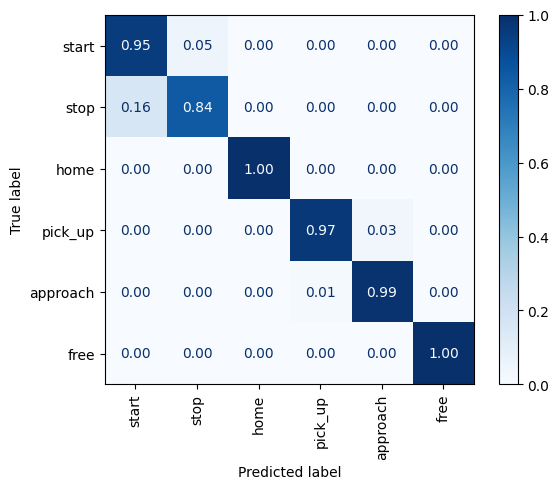

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Given confusion matrix
confusion_matrix = np.array([
    [57, 3, 0, 0, 0, 0],
    [18, 92, 0, 0, 0, 0],
    [0, 0, 75, 0, 0, 0],
    [0, 0, 0, 92, 3, 0],
    [0, 0, 0, 1, 69, 0],
    [0, 0, 0, 0, 0, 70]
])

# Normalize the confusion matrix
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_normalized, display_labels=['start', 'stop', 'home', 'pick_up', 'approach', 'free'])
disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical', ax=None)
plt.grid(False)  # Remove the grid lines from the confusion matrix plot
plt.show()

In [51]:
def predict(tensor):
    if isinstance(tensor, np.ndarray):
        tensor = torch.from_numpy(tensor)
    
    # Assuming tensor shape is [1, L] where L is the length of the waveform
    # Replicate the tensor to have 64 channels
    # tensor = tensor.repeat(3, 1, 1)  # Adjust this line based on your actual tensor shape and requirements
    
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))  # Ensure tensor is in the correct shape for the model
    tensor = get_likely_index(tensor)
    return tensor

nr = 0
for i in range(len(valid_dataset)):
    waveform, utterance = valid_dataset[i]
    if utterance != predict(waveform).item():
        nr += 1
        print(f"Expected: {utterance}. Predicted: {predict(waveform).item()}.")

print(nr)

Expected: 1. Predicted: 0.
Expected: 0. Predicted: 3.
Expected: 1. Predicted: 0.
Expected: 5. Predicted: 4.
4


    SPEAKER RECOGNITION

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import librosa
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Define the dataset class
class My_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, set_number, sample_rate=16000, n_mfcc=13, n_mels=128):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.sample_rate = sample_rate
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        return [idx for idx in range(len(self.data)) if int(self.data.iloc[idx, 1]) == self.set_number]

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        speaker_label = int(self.data.iloc[idx, 3]) 
        try:
            waveform, _ = librosa.load(file, sr=self.sample_rate)
            spectrogram = librosa.feature.melspectrogram(y=waveform, sr=16000, n_mels=128, hop_length=128, n_fft=2048)
            spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            spectrogram = np.expand_dims(spectrogram, axis=0)  # Add channel dimension
            return torch.tensor(spectrogram, dtype=torch.float32), torch.tensor(speaker_label, dtype=torch.long)
        except Exception as e:
            print(f"Error loading {file}: {e}")
            return self.__getitem__((idx + 1) % len(self.filtered_indices))  # Load next sample

# Load the datasets
csv_file = 'dataset.csv'
root_dir = 'Inregistrari'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)

In [3]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):

    print(X.shape, y.shape)
    if batch == 3:
        break

#dimensiuni: cat mai patrat - 128x128
    

torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])
torch.Size([64, 1, 128, 126]) torch.Size([64])


In [4]:
def get_vgg(version=16, freeze=False, num_classes=10, device='cpu'):
    vgg = models.__dict__[f'vgg{version}'](pretrained=True)
    
    if freeze:
        for param in vgg.parameters():
            param.requires_grad = False
    
    # Modify the first convolutional layer to accept 1 input channel
    vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    
    # Modify the fully connected layer to match the number of classes
    vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=num_classes, bias=True)
    
    return vgg.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_vgg(version=16, num_classes=8, device=device)
print(model)


c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Antonia\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [5]:

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate
criterion = nn.CrossEntropyLoss()

In [6]:
train_losses = []
train_accuracies = []

# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    scheduler.step()

In [7]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

test_losses = []
test_accuracies = []
all_preds = []
all_targets = []

# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')


In [8]:
n_epoch = 20
log_interval = 20

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, device, train_loader, optimizer, epoch, log_interval, scheduler)
        test(model, device, test_loader)
        torch.save(model.state_dict(), 'vgg_speaker.pt')
        pbar.update(1)


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1 [0/336 (0%)]	Loss: 5.623324

Test set: Average loss: 2.0722, Accuracy: 17/96 (18%)



  5%|▌         | 1/20 [01:10<22:21, 70.62s/it]

Train Epoch: 2 [0/336 (0%)]	Loss: 2.026391

Test set: Average loss: 2.0760, Accuracy: 11/96 (11%)



 10%|█         | 2/20 [02:19<20:53, 69.66s/it]

Train Epoch: 3 [0/336 (0%)]	Loss: 2.022486

Test set: Average loss: 1.9054, Accuracy: 32/96 (33%)



 15%|█▌        | 3/20 [03:29<19:43, 69.63s/it]

Train Epoch: 4 [0/336 (0%)]	Loss: 1.842519

Test set: Average loss: 1.5461, Accuracy: 49/96 (51%)



 20%|██        | 4/20 [04:37<18:23, 68.97s/it]

Train Epoch: 5 [0/336 (0%)]	Loss: 1.586853

Test set: Average loss: 1.3992, Accuracy: 45/96 (47%)



 25%|██▌       | 5/20 [05:48<17:25, 69.70s/it]

Train Epoch: 6 [0/336 (0%)]	Loss: 1.286680

Test set: Average loss: 1.4276, Accuracy: 48/96 (50%)



 30%|███       | 6/20 [06:57<16:15, 69.69s/it]

Train Epoch: 7 [0/336 (0%)]	Loss: 1.393641

Test set: Average loss: 1.1950, Accuracy: 52/96 (54%)



 35%|███▌      | 7/20 [08:07<15:05, 69.68s/it]

Train Epoch: 8 [0/336 (0%)]	Loss: 1.202263

Test set: Average loss: 0.4330, Accuracy: 81/96 (84%)



 40%|████      | 8/20 [09:15<13:51, 69.26s/it]

Train Epoch: 9 [0/336 (0%)]	Loss: 0.373059

Test set: Average loss: 0.3047, Accuracy: 85/96 (89%)



 45%|████▌     | 9/20 [10:25<12:44, 69.51s/it]

Train Epoch: 10 [0/336 (0%)]	Loss: 0.288229

Test set: Average loss: 0.3860, Accuracy: 84/96 (88%)



 50%|█████     | 10/20 [11:33<11:28, 68.83s/it]

Train Epoch: 11 [0/336 (0%)]	Loss: 0.169613

Test set: Average loss: 0.3943, Accuracy: 83/96 (86%)



 55%|█████▌    | 11/20 [12:41<10:18, 68.75s/it]

Train Epoch: 12 [0/336 (0%)]	Loss: 0.309183

Test set: Average loss: 0.2222, Accuracy: 93/96 (97%)



 60%|██████    | 12/20 [18:40<20:56, 157.00s/it]

Train Epoch: 13 [0/336 (0%)]	Loss: 0.068112

Test set: Average loss: 0.1480, Accuracy: 92/96 (96%)



 65%|██████▌   | 13/20 [20:01<15:36, 133.82s/it]

Train Epoch: 14 [0/336 (0%)]	Loss: 0.027704

Test set: Average loss: 0.1957, Accuracy: 94/96 (98%)



 70%|███████   | 14/20 [21:22<11:47, 117.90s/it]

Train Epoch: 15 [0/336 (0%)]	Loss: 0.046715

Test set: Average loss: 0.1190, Accuracy: 93/96 (97%)



 75%|███████▌  | 15/20 [23:03<09:23, 112.76s/it]

Train Epoch: 16 [0/336 (0%)]	Loss: 0.026394

Test set: Average loss: 0.5946, Accuracy: 87/96 (91%)



 80%|████████  | 16/20 [24:25<06:54, 103.58s/it]

Train Epoch: 17 [0/336 (0%)]	Loss: 0.280843

Test set: Average loss: 0.2535, Accuracy: 89/96 (93%)



 85%|████████▌ | 17/20 [25:45<04:49, 96.65s/it] 

Train Epoch: 18 [0/336 (0%)]	Loss: 0.055393

Test set: Average loss: 0.1817, Accuracy: 90/96 (94%)



 90%|█████████ | 18/20 [26:58<02:58, 89.40s/it]

Train Epoch: 19 [0/336 (0%)]	Loss: 0.028820

Test set: Average loss: 0.2510, Accuracy: 90/96 (94%)



 95%|█████████▌| 19/20 [28:12<01:24, 84.75s/it]

Train Epoch: 20 [0/336 (0%)]	Loss: 0.079012

Test set: Average loss: 0.2356, Accuracy: 88/96 (92%)



100%|██████████| 20/20 [29:24<00:00, 88.24s/it]


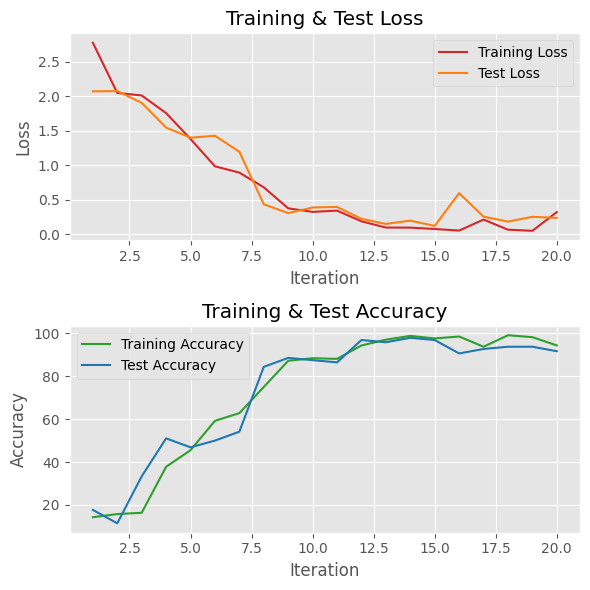

              precision    recall  f1-score   support

         Adi       0.64      0.87      0.74       180
        Anca       0.79      0.80      0.79       200
        Bobo       0.66      0.71      0.68       240
      Danila       0.66      0.75      0.70       300
        Luci       0.61      0.90      0.72       220
        Mada       0.89      0.62      0.73       260
        Oana       0.83      0.73      0.78       240
        Toni       0.98      0.56      0.71       280

    accuracy                           0.73      1920
   macro avg       0.76      0.74      0.73      1920
weighted avg       0.77      0.73      0.73      1920

[[157   2   3   0  14   4   0   0]
 [  9 159   6  13  10   0   3   0]
 [ 22   2 170   9  33   1   3   0]
 [  6   8  22 224  28   3   8   1]
 [  7   0  15   0 198   0   0   0]
 [ 28   1  17  33  18 162   0   1]
 [  1  16  11  23  12   0 176   1]
 [ 14  13  13  35  14  12  22 157]]


In [9]:
num_epochs = 150
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplot
axs[0].plot(epochs[:len(train_losses)], train_losses, label='Training Loss', color='tab:red')
axs[0].plot(epochs[:len(test_losses)], test_losses, label='Test Loss', color='tab:orange')
axs[0].set_title('Training & Test Loss')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_accuracies)], train_accuracies, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_accuracies)], test_accuracies, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

from sklearn.metrics import classification_report

# Assuming the testing loop code here

# After the testing loop
report = classification_report(all_targets, all_preds, target_names=['Adi', 'Anca','Bobo', 'Danila', 'Luci', 'Mada', 'Oana', 'Toni' ])  # Adjust target_names based on your dataset
print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
print(confision_matrix)